##**Fashion GANerator**

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

In [ ]:
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

import sys
print("python version", sys.version)
print("TF version", tf.__version__)
if tf.test.is_gpu_available():
  print("GPU available")
else:
  print("GPU unavailable")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


python version 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
TF version 2.12.0
GPU available


In [ ]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train[np.isin(y_train,[9])] # Number 9 is "ankle boot"

# modification: reducing dataset to save time
print("original dataset size: ", len(x_train), len(x_test))
x_train = x_train[:100]
x_test = x_test[:100]

x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] Section
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print("reduced dataset size: ", len(x_train), len(x_test))

4422102/4422102 [==============================] - 0s 0us/step
original dataset size:  6000 10000
reduced dataset size:  100 100


In [ ]:
batch_siz=64
epochs=500
dropout_rate=0.4
batch_norm=0.9
zdim=100 # dimensions of latent space

In [ ]:
# Discriminator Network D Design
discriminator_input=Input(shape=(28, 28, 1))
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0     

In [ ]:
# Generator Network G Design
generator_in_channels = 32

generator_input=Input(shape=(zdim,))
x=Dense(7*7*generator_in_channels)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,generator_in_channels))(x)
x=UpSampling2D()(x)
x=Conv2D(64,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 1568)              158368    
                                                                 
 batch_normalization (BatchN  (None, 1568)             6272      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1568)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                         

In [ ]:
discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
trainable_count_d = np.sum([K.count_params(w) for w in discriminator.trainable_weights])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         259361    
                                                                 
 model (Functional)          (None, 1)                 113473    
                                                                 
Total params: 372,834
Trainable params: 255,841
Non-trainable params: 116,993
_________________________________________________________________


In [ ]:
trainable_count_g = np.sum([K.count_params(w) for w in gan.trainable_weights])
print('[Baseline] Trainable params: {:,} for D \n\t\t\tand {:,} for GAN'
    .format(trainable_count_d, trainable_count_g))

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))

import time
start_time = time.time()

[Baseline] Trainable params: 113,473 for D 
			and 255,841 for GAN


1/1 [==============================] - 0s 20ms/step


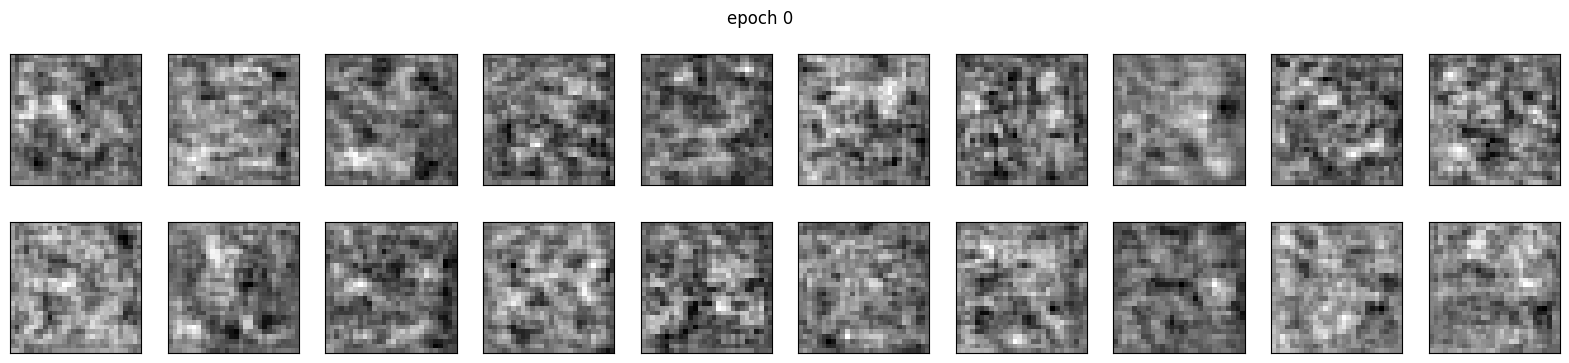

1/1 [==============================] - 0s 34ms/step


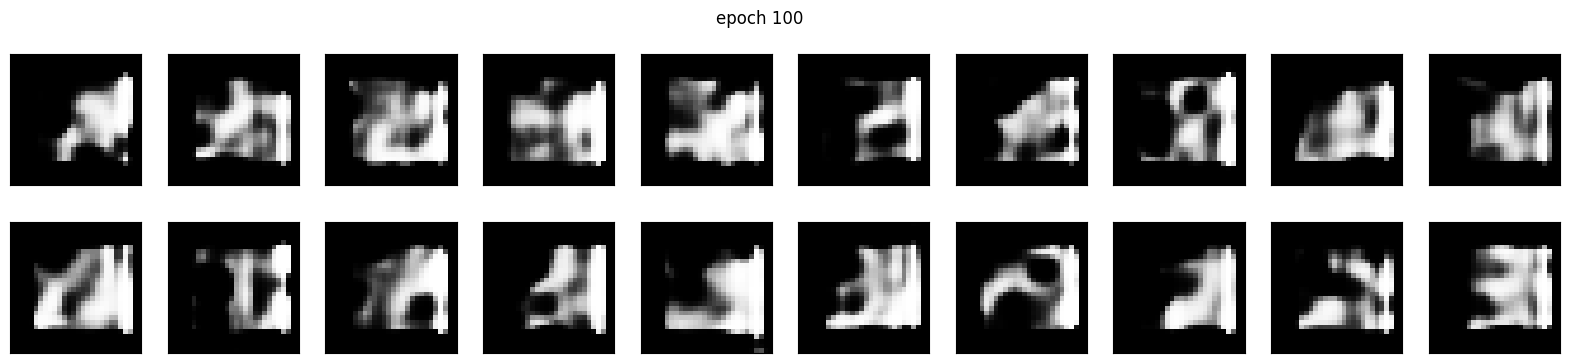

1/1 [==============================] - 0s 18ms/step


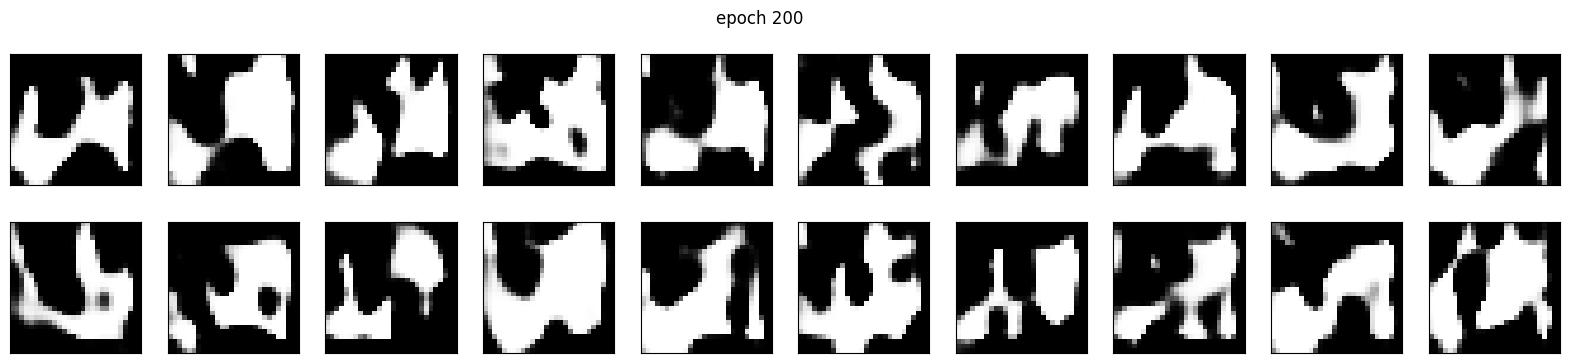

1/1 [==============================] - 0s 66ms/step


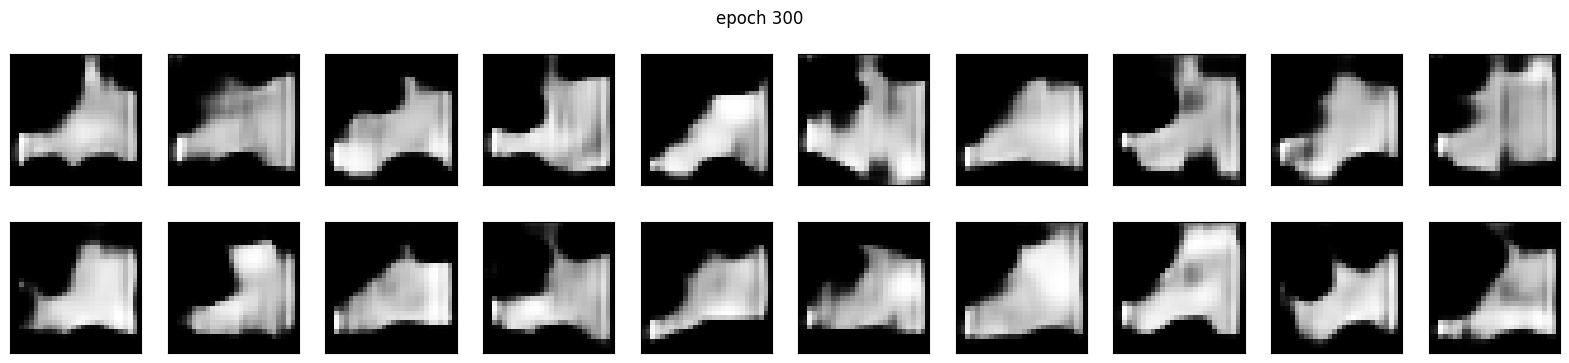

1/1 [==============================] - 0s 18ms/step


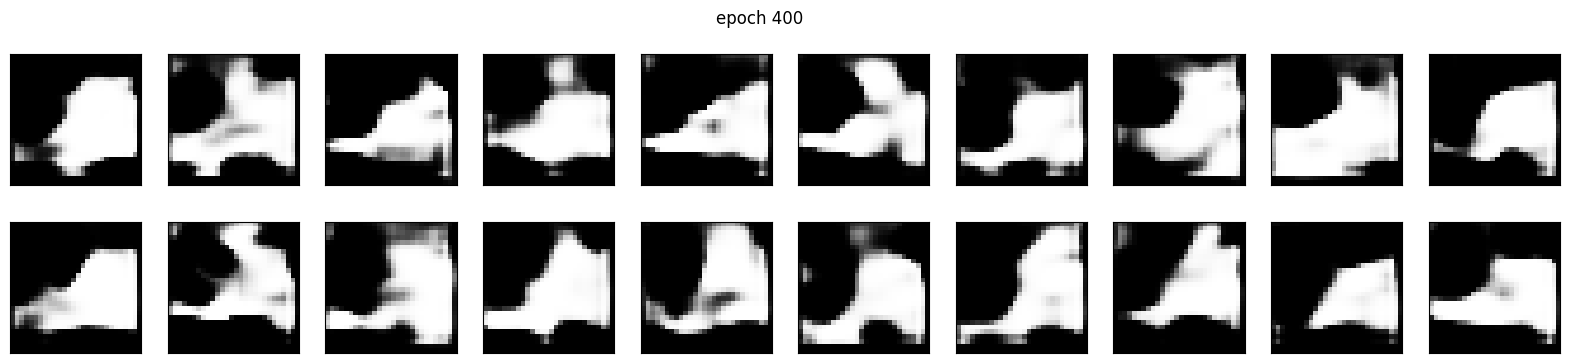

1/1 [==============================] - 0s 22ms/step


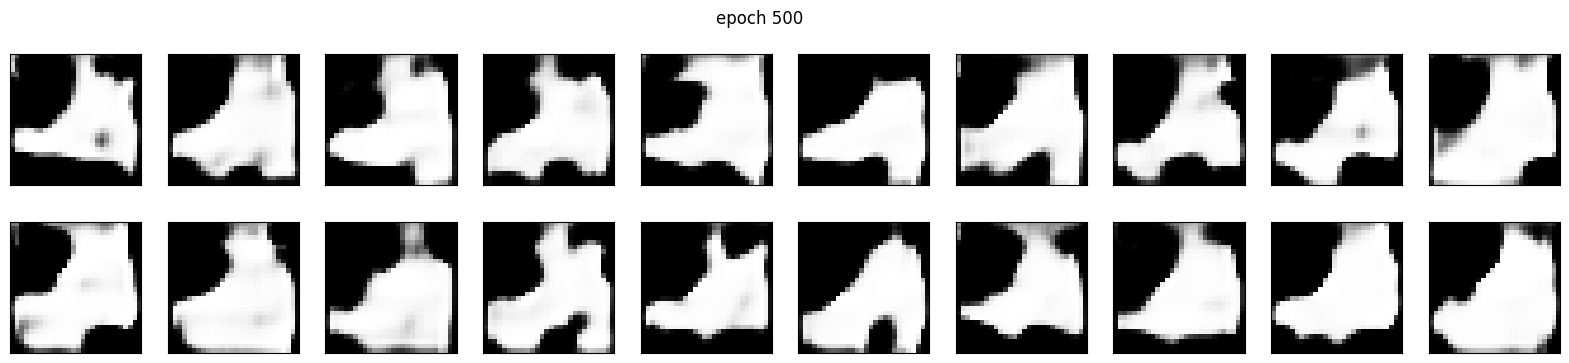

In [ ]:
for i in range(epochs+1): # Performing learning
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # Intermediate output per 100 generations during learning
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

g_train_time = time.time() - start_time

1/1 [==============================] - 0s 165ms/step


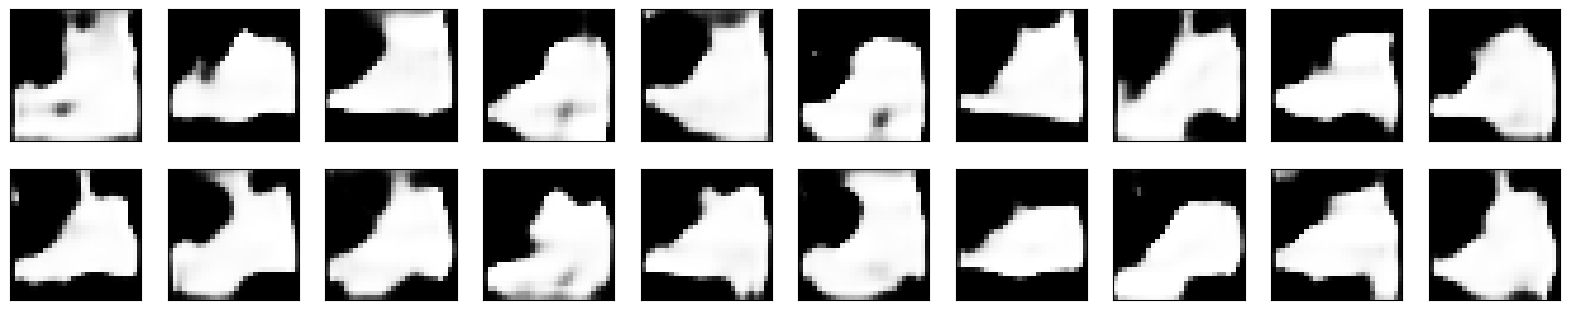

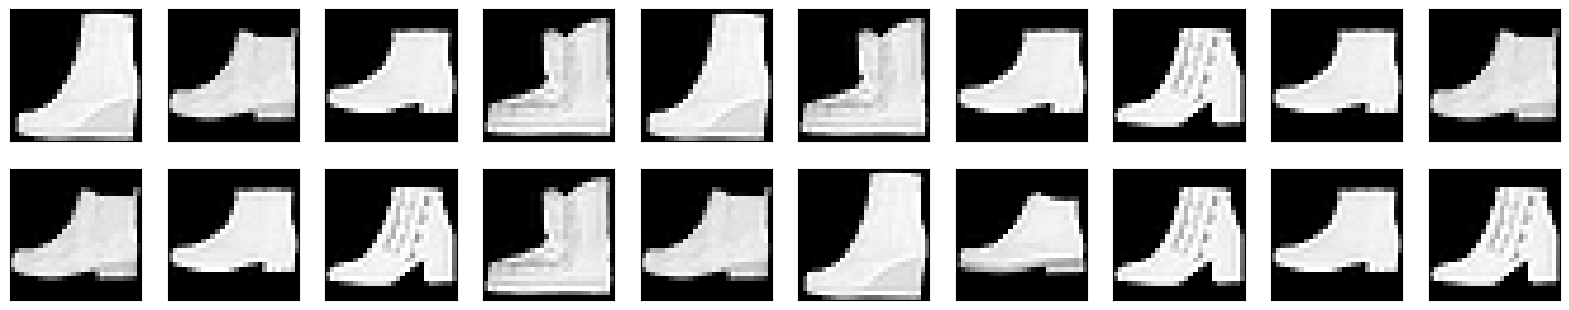

In [ ]:
imgs=generator.predict(np.random.normal(0,1,(20,zdim)))
plt.figure(figsize=(20,10)) # Create and output 20 samples after learning is completed
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])

# Function to find the image closest to img in training set x_train
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
    return x_train[imin], vmin

# Find and display the closest image among 20 images
vminlist = []
plt.figure(figsize=(20,10))
for k in range(20):
    plt.subplot(5,10,k+1)
    img, vmin = most_similar(imgs[k],x_train)
    vminlist.append(vmin)
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

#print('Param: {}, Difference: {:6.4f}, Time: {:5.2f}'.format(trainable_count, sum(vminlist)/20, g_train_time))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 dropout_5 (Dropout)         (None, 4, 4, 64)          0   

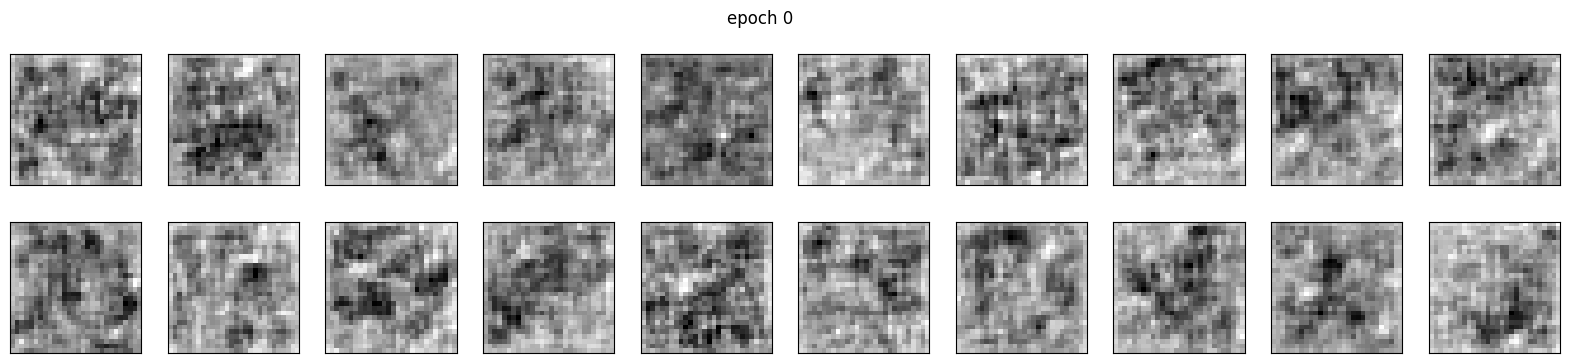

1/1 [==============================] - 0s 18ms/step


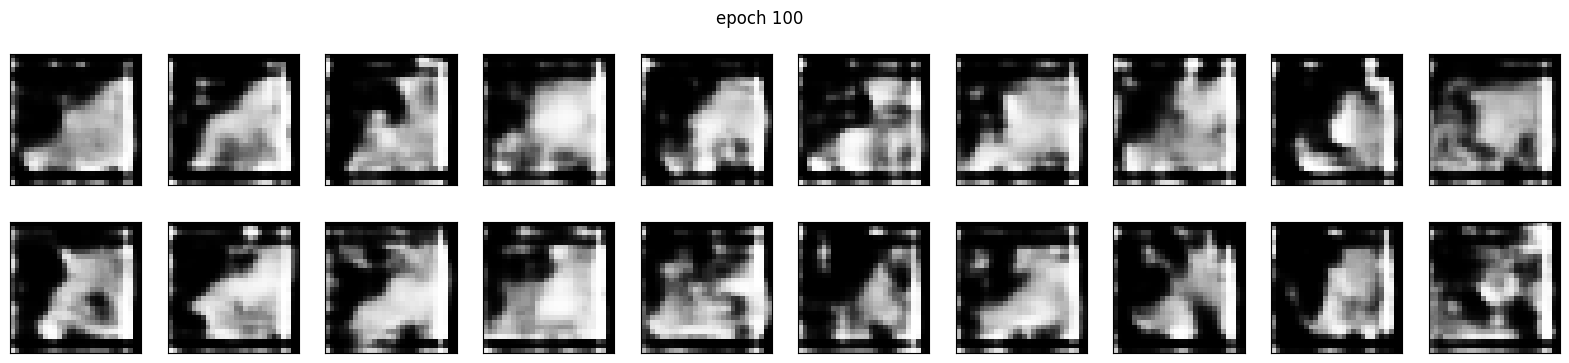

1/1 [==============================] - 0s 18ms/step


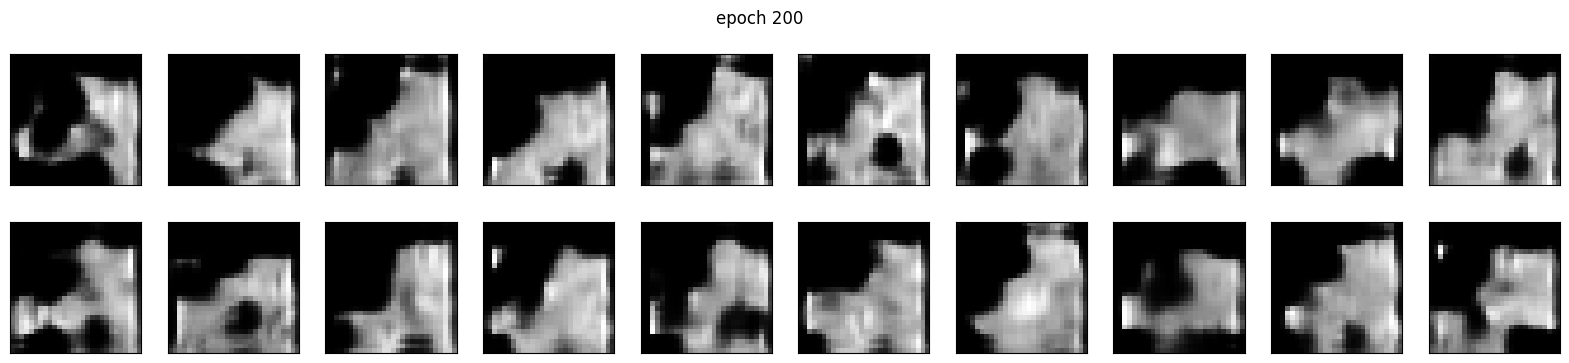

1/1 [==============================] - 0s 19ms/step


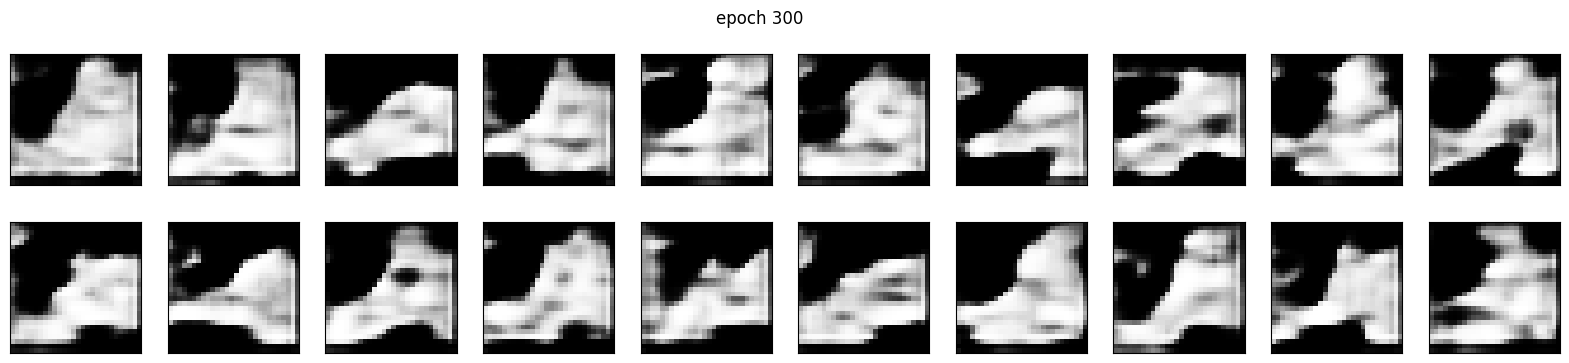

1/1 [==============================] - 0s 21ms/step


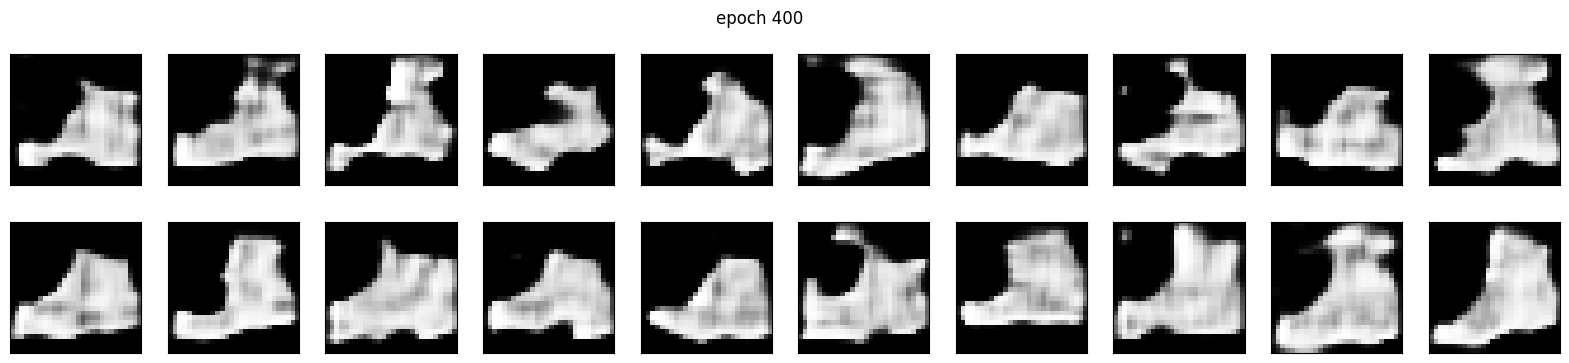

1/1 [==============================] - 0s 137ms/step


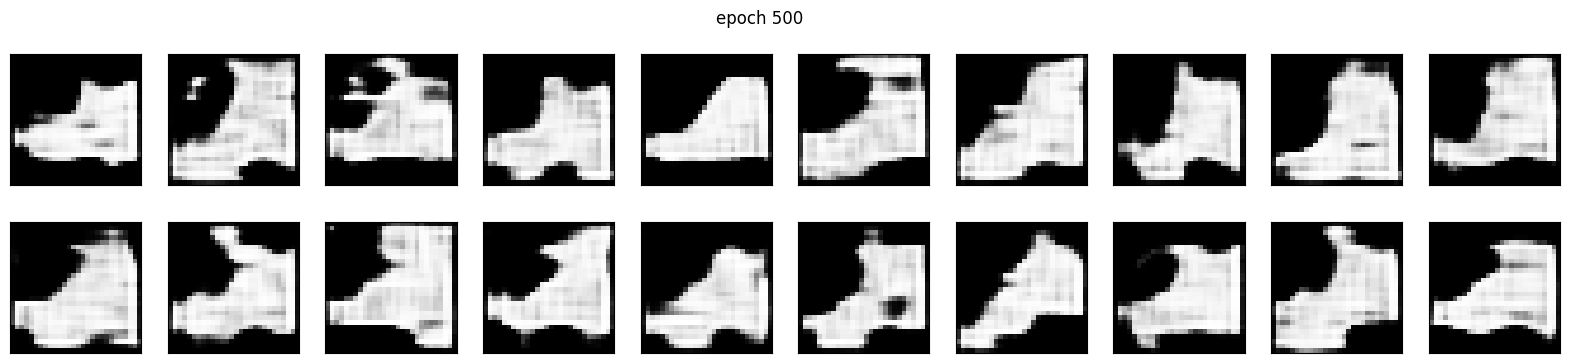

1/1 [==============================] - 0s 433ms/step


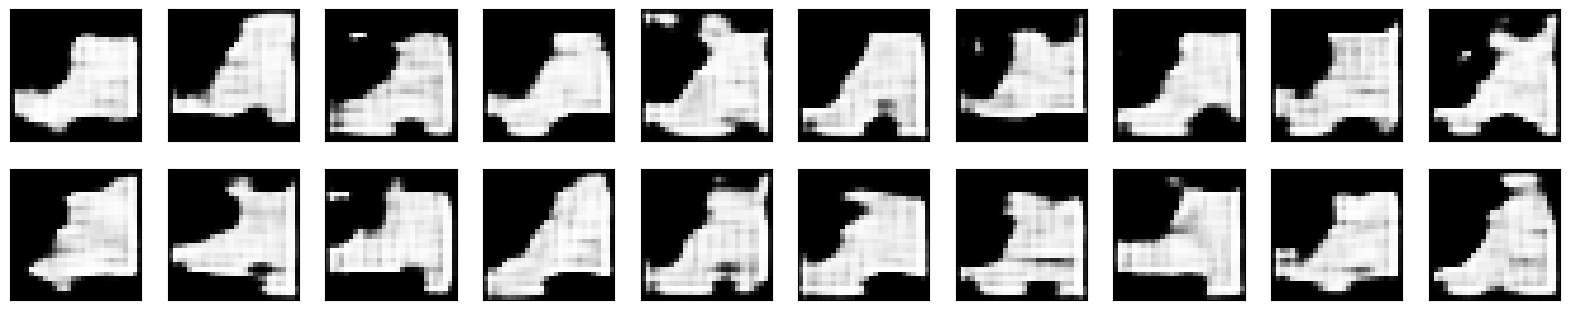

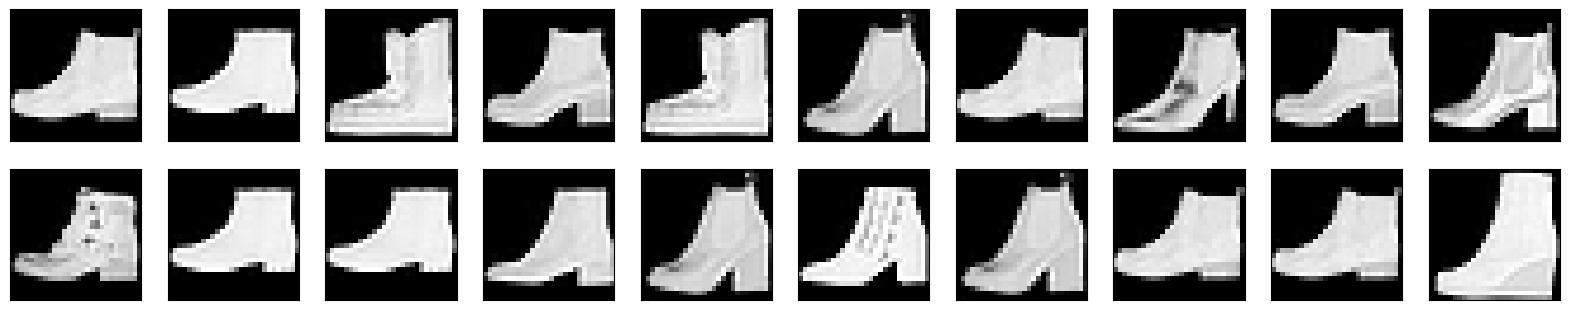

Succesful in reducing discriminator's size
Succesful in reducing GAN's size
Discriminator Size Ratio: 25.6%
GAN Size Ratio: 41.0%
	 Difference: 1.1492, Time: 77.71
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_4 (Functional)        (None, 28, 28, 1)         106641    
                                                                 
 model_3 (Functional)        (None, 1)                 29089     
                                                                 
Total params: 135,730
Trainable params: 104,881
Non-trainable params: 30,849
_________________________________________________________________


In [ ]:
# New and better GAN

# Discriminator Network D Design
discriminator_input=Input(shape=(28, 28, 1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)
discriminator.summary()

# Generator Network G Design
generator_in_channels = 16

generator_input=Input(shape=(zdim,))
x=Dense(7*7*generator_in_channels)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,generator_in_channels))(x)
x=UpSampling2D()(x)
x=Conv2D(32,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(32,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(32,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)
generator.summary()

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
your_trainable_count_d = np.sum([K.count_params(w) for w in discriminator.trainable_weights])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
your_gan=Model(gan_input,gan_output)
your_gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

your_gan.summary()
your_trainable_count_g = np.sum([K.count_params(w) for w in your_gan.trainable_weights])
print('[D] Trainable params: {:,}'.format(your_trainable_count_d))
print('[GAN] Trainable params: {:,}'.format(your_trainable_count_g))

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    your_gan.train_on_batch(p,np.ones((batch_siz,1)))

import time
start_time = time.time()

for i in range(epochs+1): # Perform learning
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # Intermediate output every 20 generations during learning
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

g_train_time = time.time() - start_time

imgs=generator.predict(np.random.normal(0,1,(20,zdim)))
plt.figure(figsize=(20,10)) # Create and output 20 samples after learning is completed
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])

# Function to find the image closest to img in training set x_train
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
    return x_train[imin], vmin

# Find and show the closest image for 20 images
your_vminlist = []
plt.figure(figsize=(20,10))
for k in range(20):
    plt.subplot(5,10,k+1)
    img, vmin = most_similar(imgs[k],x_train)
    your_vminlist.append(vmin)
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()


if (your_trainable_count_d) / trainable_count_d < 0.5:
  print("Succesful in reducing discriminator's size")
if (your_trainable_count_g) / trainable_count_g < 0.5:
  print("Succesful in reducing GAN's size")

print('Discriminator Size Ratio: {:.1%}'
  .format((your_trainable_count_d) / trainable_count_d) )
print('GAN Size Ratio: {:.1%}\n\t Difference: {:6.4f}, Time: {:5.2f}'
  .format((your_trainable_count_g) / trainable_count_g,
        (sum(vminlist) - sum(your_vminlist)), g_train_time))

your_gan.summary()

In [ ]:
import sys
print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

Python version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
NumPy version: 1.22.4
TensorFlow version: 2.12.0
